In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/Emotion_tool/DATA/

/content/gdrive/.shortcut-targets-by-id/1JsEhn2FdoXSK8DWe1dfr-hF08zxqrdrs/Emotion_tool/DATA


In [ ]:
import zipfile
with zipfile.ZipFile("./test_emotions_6cat.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [ ]:
# base_path='fer_ckplus_kdef_data66-24-10/train'
# dest_folder = 'fer-subsample/train'
# for subfolder in os.listdir(base_path):
#   img_path_ls=os.listdir(f'{base_path}/{subfolder}')
#   img_path_ls = img_path_ls[0:int(0.1*len(img_path_ls))]
#   for img_path in img_path_ls:
#     source_path=f'{base_path}/{subfolder}/{img_path}'
#     dest_path=f'{dest_folder}/{subfolder}/{img_path}'
#     try:
#       os.mkdir(f'{dest_folder}/{subfolder}')
#     except:
#       pass
#     shutil.copy(source_path, dest_path)

KeyboardInterrupt: ignored

In [ ]:
# import zipfile
# # with zipfile.ZipFile("fer-subsample-20220303T155533Z-001.zip","r") as zip_ref:
# #     zip_ref.extractall("fer-subsample-20220303T155533Z-001")


# with zipfile.ZipFile("data/test_emotions.zip","r") as zip_ref:
#     zip_ref.extractall("data")

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

Data Processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size=32

#image_dataset_from_directory

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        zoom_range=0.1,
        validation_split=0.2)

val_datagen = ImageDataGenerator(
        rescale=1./255)

test_datagen = ImageDataGenerator(
        rescale=1./255)


# train_generator = train_datagen.flow_from_directory(
#         'fer-subsample-20220303T155533Z-001/fer-subsample/train',
#         target_size=(224, 224),
#         batch_size=32,
#         color_mode ='rgb',
#         class_mode='categorical',
#         subset='training')


# validation_generator = train_datagen.flow_from_directory(
#         'fer-subsample-20220303T155533Z-001/fer-subsample/train',
#         target_size=(224, 224),
#         batch_size=32,
#         color_mode ='rgb',
#         class_mode='categorical',
#         subset='validation')



In [ ]:
test_generator = test_datagen.flow_from_directory(
        './test_emotions_6cat',
        target_size=(224, 224),
        batch_size=50,
        color_mode ='rgb',
        class_mode='categorical')

Found 40 images belonging to 6 classes.


Training Base Model

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

#specify base model
base_model = ResNet152V2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None)

#Freeze the model
base_model.trainable=False

Training 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def initialize_model(base_model):
    model = Sequential()
    model.add(layers.InputLayer(input_shape=(224,224,3))) #change input shape
    model.add(base_model)

    model.add(layers.Flatten())
    
    
    #modify04
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu')) 
    model.add(layers.Dropout(0.5))

    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.BatchNormalization())
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(8, activation='softmax'))

    ### Compile model
    model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
    return model

In [ ]:
model = initialize_model(base_model)

In [ ]:
# Some explaination of what train_generator returning
# train_generator is a list of 165 tuples (because our `train_generator.samples`/32 is 165 batches )
# train_generator[0] is the tuple of the first batch conatining 32 X images and 32 y targets

train_generator[0][0].shape #X of the first batch has 32 images 
train_generator[0][1].shape #y of the first batch contains 32 targets matching our X 

(32, 8)

In [ ]:
x,y = train_generator[0]

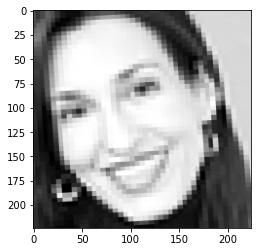

In [ ]:
plt.imshow(x[0])

In [ ]:
# model.summary()
train_generator.samples

1742

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, None, None, 2048)  58331648  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

NameError: name 'train_generator_tmp' is not defined

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=6)

model.fit(
        train_generator, #change
        epochs=50,
        validation_data=validation_generator, #change
        validation_steps=validation_generator.samples // batch_size,
        callbacks=[es])

Epoch 1/50
55/55 [==============================] - 31s 435ms/step - loss: 2.2629 - accuracy: 0.2434 - val_loss: 2.2209 - val_accuracy: 0.3606
Epoch 2/50
55/55 [==============================] - 22s 393ms/step - loss: 1.8525 - accuracy: 0.3697 - val_loss: 1.5731 - val_accuracy: 0.4712
Epoch 3/50
55/55 [==============================] - 22s 393ms/step - loss: 1.6496 - accuracy: 0.4323 - val_loss: 1.4863 - val_accuracy: 0.4856
Epoch 4/50
55/55 [==============================] - 21s 387ms/step - loss: 1.5129 - accuracy: 0.4736 - val_loss: 1.4246 - val_accuracy: 0.5240
Epoch 5/50
55/55 [==============================] - 22s 394ms/step - loss: 1.3647 - accuracy: 0.5235 - val_loss: 1.4019 - val_accuracy: 0.5168
Epoch 6/50
55/55 [==============================] - 22s 392ms/step - loss: 1.3407 - accuracy: 0.5299 - val_loss: 1.3569 - val_accuracy: 0.5192
Epoch 7/50
55/55 [==============================] - 22s 391ms/step - loss: 1.2120 - accuracy: 0.5758 - val_loss: 1.3914 - val_accuracy: 0.4808

In [ ]:
# X_traingen contains both x and also target

Predict

In [ ]:
x_ev[8].shape

(224, 224, 3)

In [ ]:
model.evaluate(x_ev,y_ev)

1/1 [==============================] - 1s 897ms/step - loss: 5.2995 - accuracy: 0.3333


[5.2995195388793945, 0.3333333432674408]

Save Model

In [ ]:
model.save('./models/my_checkpoint_pn_30k_model_04.h5')

In [ ]:
pwd

'/home/jupyter'

Load model

In [ ]:
from tensorflow.keras.models import load_model
model_02 = load_model('/home/jupyter/models/my_checkpoint_pn_30k_model_02.h5')

2022-03-07 09:52:32.888574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 09:52:32.898901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 09:52:32.899517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-07 09:52:32.901080: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [ ]:
model_02.evaluate(x_ev,y_ev)

1/1 [==============================] - 3s 3s/step - loss: 9.3167 - accuracy: 0.1875


[9.316692352294922, 0.1875]

In [ ]:
show_result(model_02)

NameError: ignored

In [ ]:
model_03 = load_model('/home/jupyter/models/my_checkpoint_pn_30k_model_03.h5')

In [ ]:
model_03.evaluate(x_ev,y_ev)

1/1 [==============================] - 2s 2s/step - loss: 5.7777 - accuracy: 0.1875


[5.777661323547363, 0.1875]

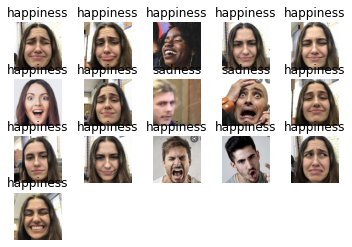

In [ ]:
show_result(model_03)

Load and test model


In [ ]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [ ]:
model_07 = load_model('../models/my_checkpoint_pn_30k_alldata_07.h5')

In [ ]:
# spliting X_testgen to X and the target
x_ev,y_ev = test_generator[0]
x_ev.shape

# emotion = {0:'anger',1:'contempt',2:'disgust',3:'fear',4:'happiness',
#            5:'neutrality',6:'sadness',7:'surprise'}
# emotion = {0:'anger',1:'disgust',2:'fear',3:'happiness',4:'neutrality',
#            5:'neutrality',6:'sadness',7:'surprise'}   
emotion = {0:'anger',1:'disgust',2:'happiness',3:'neutrality',4:'sadness',5:'surprise'}      

def show_result(model):
    for i in range(16):
        plt.subplot(4,int(15/3),i+1)
        pred = emotion[np.argmax(model.predict(x_ev[i:i+1]))]
        plt.title(pred)
        plt.imshow(x_ev[i])
        plt.axis('off')


In [ ]:
model_07.evaluate(x_ev,y_ev)

2/2 [==============================] - 26s 6s/step - loss: 4.8288 - accuracy: 0.3500


[4.828772068023682, 0.3499999940395355]

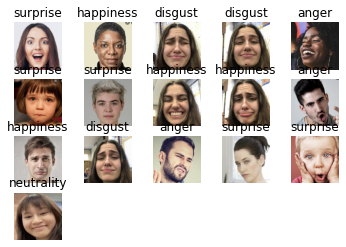

In [ ]:
show_result(model_07)

In [ ]:
#confusion metric
from sklearn.metrics import classification_report, confusion_matrix
 
pred_list = []; actual_list = []
predictions=model_07.predict(x_ev)
for i in predictions:
 
  pred_list.append(np.argmax(i))
for i in y_ev:
 
  actual_list.append(np.argmax(i))

cm=confusion_matrix(actual_list, pred_list)
cm

#rows are the actual no. of images

array([[3, 2, 0, 0, 0, 3],
       [1, 3, 2, 1, 0, 1],
       [1, 1, 2, 1, 0, 0],
       [0, 0, 3, 0, 0, 2],
       [0, 2, 4, 0, 0, 2],
       [0, 0, 0, 0, 0, 6]])

Text(33.0, 0.5, 'pred_list')

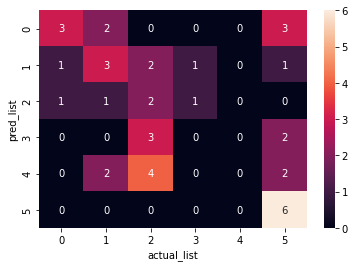

In [ ]:
import seaborn as sn

sn.heatmap(cm,annot=True,fmt='d')

### feel like the label need to swap here ##
plt.xlabel("actual_list")
plt.ylabel("pred_list")

In [ ]:
for i,e in emotion.items():
  acc = round(cm[i,i]/sum(cm[i])*100,1)
  print(f'{acc} % model correctly predict {e}')

37.5 % model correctly predict anger
37.5 % model correctly predict disgust
40.0 % model correctly predict happiness
0.0 % model correctly predict neutrality
0.0 % model correctly predict sadness
100.0 % model correctly predict surprise
